# Test Argopy, xarray (pydap) et visu matplotlibholoviews/hvplots 

In [1]:
from argopy import IndexFetcher as ArgoIndexFetcher
import xarray as xr
import cartopy.crs as crs
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
from argopy import DataFetcher as ArgoDataFetcher
import holoviews as hv
from holoviews import opts
import pyproj
import geoviews as gv

/home/tletou/micromamba_envs/envs/phyocean-2023.05/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.17, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
lat0, lat1 = 40, 60
lon0, lon1 = -30.,0.
proj = crs.Mercator()
#proj = crs.Orthographic()

In [4]:
# Get ARGO Float BayOfBiscay
idx = ArgoIndexFetcher().float(6903077).load()

In [5]:
# Convert ArgoPy to Pandas Dataframe
df_idx = idx.to_xarray()
df_idx.to_dataframe().head(3)

file                date   
index                                                                   
0      coriolis/6903077/profiles/R6903077_001D.nc 2021-11-15 08:55:00  \
1       coriolis/6903077/profiles/R6903077_001.nc 2021-11-17 05:27:20   
2       coriolis/6903077/profiles/R6903077_002.nc 2021-11-27 10:20:20   

       longitude  latitude ocean  profiler_code institution_code   
index                                                              
0         -6.187    46.455     A            878               IF  \
1         -6.216    46.490     A            878               IF   
2         -6.426    46.598     A            878               IF   

              date_update      wmo      institution profiler  
index                                                         
0     2022-09-01 01:35:25  6903077  Ifremer, France  Unknown  
1     2022-09-01 01:35:26  6903077  Ifremer, France  Unknown  
2     2022-09-01 01:35:28  6903077  Ifremer, France  Unknown

In [6]:
# Load ETOPO2 Bathymetry
#bathy = '/net/alpha/exports/sciences/data/REFERENCE_DATA/BATHYMETRY/DATA/bathy_etopo2.nc'
#ds_bathy = xr.open_dataset(bathy)
ds_bathy = xr.open_dataset("http://gamone.whoi.edu/thredds/dodsC/usgs/data0/bathy/ETOPO2v2c_f4.nc").rename({'x': 'longitude','y': 'latitude'})
ds_bathy

<xarray.Dataset>
Dimensions:    (longitude: 10800, latitude: 5400)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * latitude   (latitude) float32 -89.98 -89.95 -89.92 ... 89.92 89.95 89.98
Data variables:
    z          (latitude, longitude) float32 ...
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

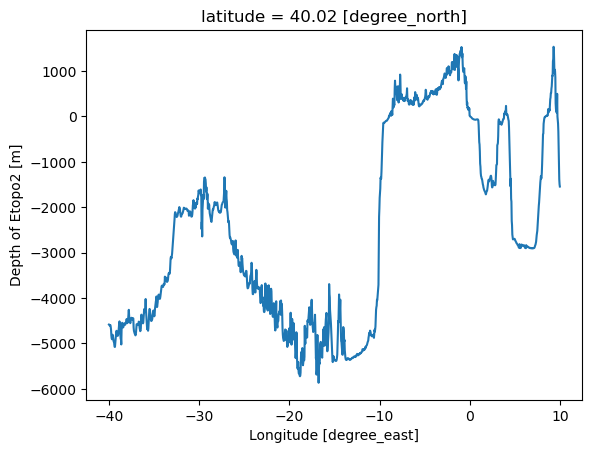

In [7]:
ds_bathy['latitude'] = ds_bathy.latitude.assign_attrs({"long_name" : "Latitude",
                                                         "units" : "degree_north",
                                                         "valid_min" : "-90.0",
                                                         "valid_max" : "90.0"})
ds_bathy['longitude'] = ds_bathy.longitude.assign_attrs({"long_name" : "Longitude",
                                                         "units" : "degree_east",
                                                         "valid_min" : "-180.0",
                                                         "valid_max" : "180.0"})
ds_bathy['z'] = ds_bathy.z.assign_attrs({"long_name" : "Depth of Etopo2",
                                                         "units" : "m",
                                                         "positive" : "up"})
attrs = {"convention": "COARDS",
         "south_latitude" : -90,
         "north_latitude" : 90,
         "west_longitude" : -180,
         "east_longitude" : 180 }
ds_bathy_attrs = ds_bathy.sel(latitude=slice(30, 70), longitude=slice(-40.,10.)).assign_attrs(attrs)
ds_bathy_attrs.sel(latitude=40, method='nearest')['z'].plot()

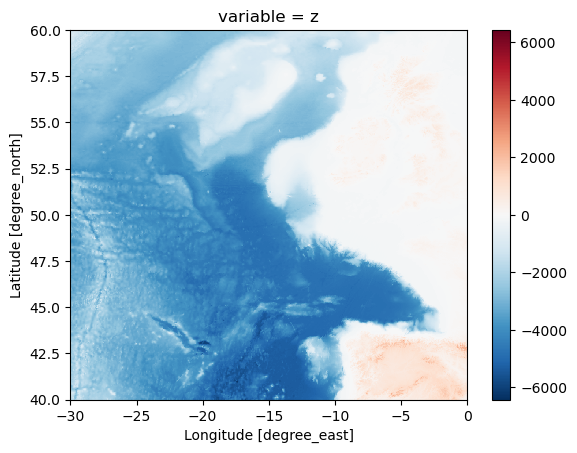

In [8]:
ds_bathy_attrs.sel(latitude=slice(40, 60), longitude=slice(-30.,0.)).to_array().plot()

In [13]:
# Workaround https://stackoverflow.com/questions/74863592/attributeerror-module-numpy-has-no-attribute-warnings
import numpy, warnings
numpy.warnings = warnings
#


# Draw points
argo_points = df_idx.to_dataframe().hvplot.points('longitude', 'latitude', geo=True)

# Draw path
argo_paths = df_idx.to_dataframe().hvplot.paths('longitude', 'latitude', geo=True)

# Draw bathy + argo float (point & path)
ds_bathy_attrs.hvplot.quadmesh('longitude', 'latitude', projection=proj, project=True, global_extent=False,
    cmap='viridis', rasterize=True, dynamic=True, coastline=True, 
    frame_width=500) * argo_points * argo_paths

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [longitude,latitude]   (z)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Points.I    :Points   [longitude,latitude]
      .Path.I      :Path   [longitude,latitude]